In [1]:
import os
import sys
sys.path.append("../")
import csv
import json
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import seaborn as sns

import settings
from prediction_dataset import PredictionDataset
from process_sentinel3 import OLCIdataGenerator

In [2]:
processed_data_path = settings.processed_data_path

DATE_FORMAT = '%Y-%m-%d'

ndci_data_path = os.path.join(settings.final_data_path, "kmeans_3", "ndci_data.csv")
precipitation_data_path = os.path.join(settings.final_data_path, "precipitation", "precipitation.csv")
wind_data_path = os.path.join(settings.final_data_path, "wind_data.csv")
water_temperature_data_path = os.path.join(settings.final_data_path, "water_temperature.csv")
algae_gt_path = os.path.join(settings.final_data_path, "algae_gt.csv")
ta_ose_path = os.path.join(settings.final_data_path, "agua_open_data(1).csv")
s3_brrs_path = os.path.join(settings.final_data_path, "s3_brrs.json")

raw_cyano_gt_path = os.path.join(settings.final_data_path, "MUESTREOS_SEMANALES_2016-2017-2018-2019-2020.xls")

bloom_thresholds = {
                    "MALLORQUINA":7000,
                    "ARROYO SAUCE": 7000,
                    "SAUCE NORTE": 7000,
                    "SAUCE SUR": 7000,
                    "CISNES": 7000,
                    "POTRERO": 7000,
                    "TA":3000
                   }

sampling_points_coords = {"SAUCE NORTE": [-34.795398, -55.047355],
                          "SAUCE SUR": [-34.843127, -55.064624],
                          "TA": [-34.829670, -55.049758]}

In [3]:
dataset = PredictionDataset(wind_data_path, water_temperature_data_path, precipitation_data_path, 
                            ndci_data_path, algae_gt_path, s3_brrs_path, bloom_thresholds=bloom_thresholds)

../prediction_dataset.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  location_data_df["label"] = days_before_bloom_col


## Blooming detection with MPH

In [4]:
# create generator that yields instances of OLCIdata from dates with ground truth
# data corrupted by clouds is skipped
data_generator = OLCIdataGenerator(processed_data_path, DATE_FORMAT, skip_invalid=True)

y_gt = {"SAUCE NORTE": [],
        "SAUCE SUR": [],
        "TA": []}

y_pred = {"SAUCE NORTE": [],
        "SAUCE SUR": [],
        "TA": []}

predicted_dates = {"SAUCE NORTE": [],
                    "SAUCE SUR": [],
                    "TA": []}

for olci_data in data_generator:
    # get gt data for same date as OLCI data
    day_fico_df = dataset.algae_gt[dataset.algae_gt["date"] == olci_data.date.date()]
    # iterate over rows, skipping unwanted gt data
    for index, row in day_fico_df.iterrows():
        if not (row["location"] in y_gt):
            continue
            
        olci_data.create_sparse_mask([sampling_points_coords[row["location"]]])
        
        immersed_mask = olci_data.mph.immersed_cyanobacteria*olci_data.mask
        count_immersed = np.count_nonzero(immersed_mask)
        
        floating_mask = olci_data.mph.floating_cyanobacteria*olci_data.mask
        count_floating = np.count_nonzero(olci_data.mph.floating_cyanobacteria*olci_data.mask)
        
        count_total = count_immersed + count_floating

        y_pred[row["location"]].append("Bloom" if count_total > 0 else "No Bloom")
        y_gt[row["location"]].append(row["label"])
        predicted_dates[row["location"]].append(olci_data.date)

SAUCE NORTE
Accuracy: 0.85
Precision: 0.6
Recall: 1.0
FPR: 0.0
FNR: 0.2


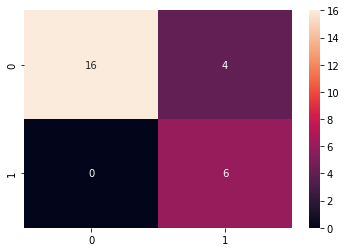

SAUCE SUR
Accuracy: 0.88
Precision: 0.73
Recall: 1.0
FPR: 0.0
FNR: 0.17


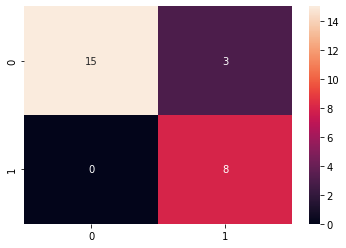

TA
Accuracy: 0.86
Precision: 0.77
Recall: 1.0
FPR: 0.0
FNR: 0.26


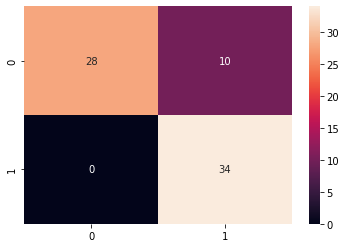

In [5]:
def metrics(gt, pred, labels=["No Bloom", "Bloom"]):
    metrics = {}
    metrics["accuracy"] = round(accuracy_score(gt, pred), 2)
    metrics["precision"] = round(precision_score(gt, pred, pos_label=labels[1]), 2)
    metrics["recall"] = round(recall_score(gt, pred, pos_label=labels[1]), 2)
    metrics["confusion matrix"] = confusion_matrix(gt, pred, labels=labels)
    metrics["false positive rate"] = round(metrics["confusion matrix"][1, 0]/(metrics["confusion matrix"][1, 1] + metrics["confusion matrix"][1, 0]), 2)
    metrics["false negative rate"] = round(metrics["confusion matrix"][0, 1]/(metrics["confusion matrix"][0, 0] + metrics["confusion matrix"][0, 1]), 2)
    
    return metrics

for location in list(y_gt.keys()):
    print(location)
    m = metrics(y_gt[location], y_pred[location])
    print("Accuracy:", m["accuracy"])
    print("Precision:", m["precision"])
    print("Recall:", m["recall"])
    print("FPR:", m["false positive rate"])
    print("FNR:", m["false negative rate"])
    sns.heatmap(m["confusion matrix"], annot=True)
    plt.show()

## Bloom detection using MPH + rain, temperature and wind

In [6]:
dataset.algae_gt

,date,location,fico,chl,label
0,2015-12-30,MALLORQUINA,5032.50,10.00,No Bloom
1,2015-12-30,ARROYO SAUCE,5345.50,21.80,No Bloom
2,2015-12-30,SAUCE NORTE,4282.50,7.50,No Bloom
3,2015-12-30,SAUCE SUR,5388.00,7.50,No Bloom
4,2015-12-30,CISNES,9082.50,18.45,Bloom
...,...,...,...,...,...
685,2020-10-31,TA,1083.00,NaN,No Bloom
686,2020-11-01,TA,47.00,NaN,No Bloom
687,2020-11-02,TA,5.96,NaN,No Bloom
688,2020-11-05,TA,9.06,NaN,No Bloom


In [7]:
sample_date = datetime(2020, 12, 1)
dataset.get_historic_data(sample_date, 5)[["date", "wind", "temperature", "precipitation"]]

,date,wind,temperature,precipitation
0,2020-12-01,4.5,17.0,0.00
1,2020-11-30,14.5,17.0,0.00
2,2020-11-29,13.5,21.0,3.51
3,2020-11-28,12.0,21.5,6.78
4,2020-11-27,9.0,18.0,0.00


### Measure correlations

In [8]:
from collections import defaultdict

infinite_defaultdict = lambda: defaultdict(infinite_defaultdict)
correlations = infinite_defaultdict() 

accumulation_methods = ["sum", "min", "max", "mean"]
# try to find correlations accumulating data from 1 to 9 days before the dates with GT
for days_before in range(1, 10, 1):
    accumulation_data = []
    for index, row in dataset.algae_gt.iterrows():
        if row["location"] not in ["SAUCE NORTE", "SAUCE SUR", "TA"]:
            continue

        row_date = datetime(row["date"].year, row["date"].month, row["date"].day, 0, 0, 0)
        historic_data = dataset.get_historic_data(row_date, days_before)

        if len(historic_data) == 0: continue

        item = {"date": row["date"], "label": row["label"]}
        for m in accumulation_methods:
            item["precipitation_" + m] = getattr(historic_data["precipitation"], m)()
            item["temperature_" + m] = getattr(historic_data["temperature"], m)()
            item["wind_" + m] = getattr(historic_data["wind"], m)()
        accumulation_data.append(item)
    
    accumulation_df = pd.DataFrame(accumulation_data)
    accumulation_df = accumulation_df[accumulation_df["date"] >= datetime(2018, 11, 1, 0, 0).date()]
    accumulation_df["numeric label"] = accumulation_df["label"].replace("No Bloom", 0)
    accumulation_df["numeric label"] = accumulation_df["numeric label"].replace("Bloom", 1)
    
    print(f"{days_before} days accumulation")
    for d in ["precipitation", "temperature", "wind"]:
        for m in accumulation_methods:
            accumulation_dataname = f"{d}_{m}"
            accumulation_correlation = accumulation_df['numeric label'].corr(accumulation_df[accumulation_dataname])
            print(f"{accumulation_dataname} ----> {accumulation_correlation}")
            correlations[d][days_before][m] = accumulation_correlation
    print("////////////")

1 days accumulation
precipitation_sum ----> -0.01874771406542977
precipitation_min ----> -0.0007145091478845336
precipitation_max ----> -0.0007145091478845336
precipitation_mean ----> -0.0007145091478845336
temperature_sum ----> -0.2852300932690982
temperature_min ----> -0.2852300932690982
temperature_max ----> -0.2852300932690982
temperature_mean ----> -0.2852300932690982
wind_sum ----> 0.08200468747022889
wind_min ----> 0.08200468747022889
wind_max ----> 0.08200468747022889
wind_mean ----> 0.08200468747022889
////////////
2 days accumulation
precipitation_sum ----> -0.07340505922413579
precipitation_min ----> 0.040011605972809026
precipitation_max ----> -0.08330499695641451
precipitation_mean ----> -0.05959169987648199
temperature_sum ----> -0.29060607532422444
temperature_min ----> -0.2822980383852778
temperature_max ----> -0.2906992382141217
temperature_mean ----> -0.29060607532422444
wind_sum ----> 0.07780353920733676
wind_min ----> 0.0203439511175491
wind_max ----> 0.110336387419

In [9]:
from collections import defaultdict

infinite_defaultdict = lambda: defaultdict(infinite_defaultdict)
correlations = infinite_defaultdict() 

accumulation_methods = ["sum", "min", "max", "mean"]
dates = dataset.algae_gt.date.unique()
# try to find correlations accumulating data from 1 to 9 days before the dates with GT
for days_before in range(1, 10, 1):
    accumulation_data = []
    for d in dates:
        date_fico = dataset.algae_gt[dataset.algae_gt["date"] == d]
        date_fico = date_fico.loc[date_fico['location'].isin(["SAUCE NORTE", "SAUCE SUR"])]
        date_fico = date_fico["fico"].mean()
        row_date = datetime(d.year, d.month, d.day, 0, 0, 0)
        historic_data = dataset.get_historic_data(row_date, days_before)

        if len(historic_data) == 0: continue

        item = {"date": d, "fico": date_fico}
        for m in accumulation_methods:
            item["precipitation_" + m] = getattr(historic_data["precipitation"], m)()
            item["temperature_" + m] = getattr(historic_data["temperature"], m)()
            item["wind_" + m] = getattr(historic_data["wind"], m)()
        accumulation_data.append(item)
    
    accumulation_df = pd.DataFrame(accumulation_data)
    
    print(f"{days_before} days accumulation")
    for dd in ["precipitation", "temperature", "wind"]:
        for m in accumulation_methods:
            accumulation_dataname = f"{dd}_{m}"
            accumulation_correlation = accumulation_df['fico'].corr(accumulation_df[accumulation_dataname])
            print(f"{accumulation_dataname} ----> {accumulation_correlation}")
            correlations[dd][days_before][m] = accumulation_correlation
    print("////////////")

1 days accumulation
precipitation_sum ----> -0.1069056594267038
precipitation_min ----> -0.10801391061682876
precipitation_max ----> -0.10801391061682876
precipitation_mean ----> -0.10801391061682876
temperature_sum ----> 0.0887076329705366
temperature_min ----> -0.1975408593509713
temperature_max ----> -0.1975408593509713
temperature_mean ----> -0.1975408593509713
wind_sum ----> 0.08098874088711086
wind_min ----> -0.08703710643539206
wind_max ----> -0.08703710643539206
wind_mean ----> -0.08703710643539206
////////////
2 days accumulation
precipitation_sum ----> -0.14334569437470773
precipitation_min ----> -0.08949014363236002
precipitation_max ----> -0.13997548477829094
precipitation_mean ----> -0.1451427243805468
temperature_sum ----> 0.09163529847443208
temperature_min ----> -0.17642253203498875
temperature_max ----> -0.22202151449150942
temperature_mean ----> -0.20279204525833697
wind_sum ----> 0.10396202433874062
wind_min ----> -0.08727225500492622
wind_max ----> -0.01601999517455

In [10]:
accumulation_df

,date,fico,precipitation_sum,temperature_sum,wind_sum,precipitation_min,temperature_min,wind_min,precipitation_max,temperature_max,wind_max,precipitation_mean,temperature_mean,wind_mean
0,2015-12-30,4835.25,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2016-01-07,13375.25,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2016-01-13,13624.75,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2016-01-23,1962.00,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2016-01-27,14956.25,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
238,2020-10-31,NaN,13.800000,135.0,90.0,0.0,11.5,5.5,8.770000,20.0,19.0,1.533333,15.000000,10.000000
239,2020-11-01,NaN,5.030000,132.0,90.0,0.0,11.5,5.5,3.290000,20.0,19.0,0.558889,14.666667,10.000000
240,2020-11-02,NaN,5.030000,128.5,89.5,0.0,11.5,5.0,3.290000,20.0,19.0,0.558889,14.277778,9.944444
241,2020-11-05,NaN,0.000000,124.0,75.0,0.0,11.5,5.0,0.000000,16.0,15.0,0.000000,13.777778,8.333333


### Find best correlations

In [11]:
for data_type in correlations.keys():
    print(data_type)
    correlations_df = pd.DataFrame(correlations[data_type])
    
    max_corr = correlations_df.max().max()
    min_corr = correlations_df.min().min()
    
    max_correlation = correlations_df.where(correlations_df==max_corr).dropna(how='all').dropna(axis=1)
    min_correlation = correlations_df.where(correlations_df==min_corr).dropna(how='all').dropna(axis=1)
    
    print(f"{max_correlation.columns.tolist()} days accumulated with {str(max_correlation.index.tolist())}: {max_corr}")
    print()
    print(f"{min_correlation.columns.tolist()} days accumulated with {min_correlation.index.tolist()}: {min_corr}")
    
    print("/////////////////////////////")
    

precipitation
[4] days accumulated with ['min']: -0.05523597969346027

[4] days accumulated with ['max']: -0.1625745733128711
/////////////////////////////
temperature
[9] days accumulated with ['sum']: 0.10109027206349608

[4] days accumulated with ['max']: -0.294787378822385
/////////////////////////////
wind
[9] days accumulated with ['max']: 0.5073917224951604

[8] days accumulated with ['min']: -0.1503666776740891
/////////////////////////////


### Data with MPH indexes and climate

In [12]:
data_generator = OLCIdataGenerator(processed_data_path, DATE_FORMAT, skip_invalid=True)

X = []
y = []

for olci_data in data_generator:
    # get gt data for same date as OLCI data
    day_fico_df = dataset.algae_gt[dataset.algae_gt["date"] == olci_data.date.date()]
    # iterate over rows, skipping unwanted gt data
    for index, row in day_fico_df.iterrows():
        if not (row["location"] in ["SAUCE NORTE", "SAUCE SUR", "TA"]):
            continue
            
        y.append(row["label"])
        
        location_coords = sampling_points_coords[row["location"]]
        
        i, j = olci_data.get_pos_index(location_coords[0], location_coords[1])
        
        # get a 3x3 grid centered on the sampling location
#         NDVI = olci_data.mph.NDVI[i-1:i+2, j-1:j+2].mean()
#         BAIR = olci_data.mph.BAIR[i-1:i+2, j-1:j+2].mean()
#         SICF = olci_data.mph.SICF[i-1:i+2, j-1:j+2].mean()
#         SIPF = olci_data.mph.SIPF[i-1:i+2, j-1:j+2].mean()
#         MPH0 = olci_data.mph.MPH0[i-1:i+2, j-1:j+2].mean()
#         MPH1 = olci_data.mph.MPH1[i-1:i+2, j-1:j+2].mean()
#         lambda_max1 = olci_data.mph.MPH1[i-1:i+2, j-1:j+2].mean()
        
#         NDVI = olci_data.mph.NDVI[i-1:i+2, j-1:j+2].min()
#         BAIR = olci_data.mph.BAIR[i-1:i+2, j-1:j+2].min()
#         SICF = olci_data.mph.SICF[i-1:i+2, j-1:j+2].min()
#         SIPF = olci_data.mph.SIPF[i-1:i+2, j-1:j+2].min()
#         MPH0 = olci_data.mph.MPH0[i-1:i+2, j-1:j+2].min()
#         MPH1 = olci_data.mph.MPH1[i-1:i+2, j-1:j+2].min()
#         lambda_max1 = olci_data.mph.MPH1[i-1:i+2, j-1:j+2].min()

#         NDVI = olci_data.mph.NDVI[i, j]
#         BAIR = olci_data.mph.BAIR[i, j]
#         SICF = olci_data.mph.SICF[i, j]
#         SIPF = olci_data.mph.SIPF[i, j]
#         MPH0 = olci_data.mph.MPH0[i, j]
#         MPH1 = olci_data.mph.MPH1[i, j]
#         lambda_max1 = olci_data.mph.MPH1[i, j]
        
        NDVI = olci_data.mph.NDVI[i-1:i+2, j-1:j+2].max()
        BAIR = olci_data.mph.BAIR[i-1:i+2, j-1:j+2].max()
        SICF = olci_data.mph.SICF[i-1:i+2, j-1:j+2].max()
        SIPF = olci_data.mph.SIPF[i-1:i+2, j-1:j+2].max()
        MPH0 = olci_data.mph.MPH0[i-1:i+2, j-1:j+2].max()
        MPH1 = olci_data.mph.MPH1[i-1:i+2, j-1:j+2].max()
        lambda_max1 = olci_data.mph.MPH1[i-1:i+2, j-1:j+2].max()
        
        X.append([NDVI, BAIR, SICF, SIPF, MPH0, MPH1, lambda_max1])
X = np.array(X)
y = np.array(y)

Accuracy: 0.85
Precision: 0.86
Recall: 0.75
FPR: 0.25
FNR: 0.08


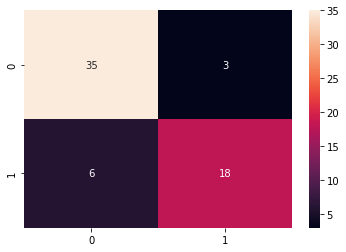

Accuracy: 0.87
Precision: 0.75
Recall: 1.0
FPR: 0.0
FNR: 0.21


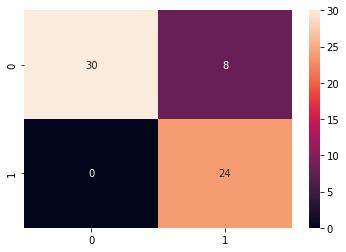

In [18]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold

clf = DecisionTreeClassifier(random_state=0, max_depth=3)
skf = StratifiedKFold(n_splits=2)
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    clf.fit(X_train, y_train)
    
    y_pred = clf.predict(X_test)
        
    m = metrics(y_test, y_pred)
    print("Accuracy:", m["accuracy"])
    print("Precision:", m["precision"])
    print("Recall:", m["recall"])
    print("FPR:", m["false positive rate"])
    print("FNR:", m["false negative rate"])
    sns.heatmap(m["confusion matrix"], annot=True)
    plt.show()

[Text(111.60000000000001, 190.26, 'SIPF <= 0.001\ngini = 0.475\nsamples = 62\nvalue = [24, 38]\nclass = Bloom'),
 Text(55.800000000000004, 135.9, 'gini = 0.0\nsamples = 37\nvalue = [0, 37]\nclass = Bloom'),
 Text(167.4, 135.9, 'SICF <= -0.002\ngini = 0.077\nsamples = 25\nvalue = [24, 1]\nclass = No Bloom'),
 Text(111.60000000000001, 81.53999999999999, 'gini = 0.0\nsamples = 23\nvalue = [23, 0]\nclass = No Bloom'),
 Text(223.20000000000002, 81.53999999999999, 'SIPF <= 0.001\ngini = 0.5\nsamples = 2\nvalue = [1, 1]\nclass = No Bloom'),
 Text(167.4, 27.180000000000007, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]\nclass = No Bloom'),
 Text(279.0, 27.180000000000007, 'gini = 0.0\nsamples = 1\nvalue = [0, 1]\nclass = Bloom')]

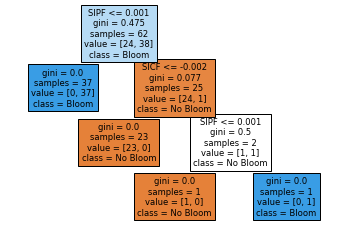

In [19]:
from sklearn import tree


tree.plot_tree(clf, 
               feature_names=["NDVI", "BAIR", "SICF", "SIPF", "MPH0", "MPH1", "lambda_max1"],  
               class_names=["No Bloom", "Bloom"],
               filled=True)

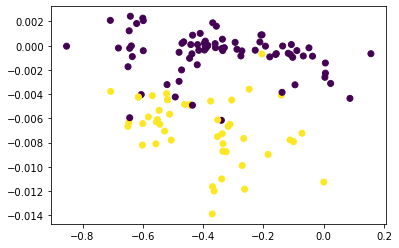

In [31]:
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 2], c=y_binary)
plt.show()

In [28]:
y_binary = np.zeros(y.shape)
for i in range(y_binary.shape[0]):
    if y[i] == "No Bloom":
        y_binary[i] = 0
    else:
        y_binary[i] = 1

In [29]:
y_binary

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.,
       0., 0., 0., 0., 0.])

In [32]:
X[:, 0]

array([-7.07831383e-01, -6.41366959e-01, -5.98553360e-01, -6.20619416e-01,
       -3.56281370e-01, -3.68181258e-01, -3.85548621e-01, -4.64434415e-01,
       -2.08411783e-01, -2.04631478e-01, -3.95630538e-01, -6.80988312e-01,
       -4.35045034e-01, -2.11847916e-01, -6.00097477e-01, -6.45411432e-01,
       -1.78993061e-01, -2.04934552e-01, -4.79837447e-01, -6.05251491e-01,
       -4.44295734e-01, -4.70271766e-01, -7.22690523e-02, -1.00431211e-01,
       -1.11807115e-01, -1.84587136e-01, -2.70545900e-01, -5.43385148e-01,
       -2.47449189e-01,  5.51073253e-03,  5.31536806e-03,  3.82439070e-03,
        2.28128769e-02, -9.53266174e-02, -1.59476385e-01, -1.02966711e-01,
       -1.09981880e-01, -6.78724125e-02, -8.91201571e-02, -2.27301225e-01,
       -4.37178969e-01, -1.93319127e-01, -4.44949627e-01, -2.74830222e-01,
       -4.19578612e-01, -3.72031592e-02, -2.71541595e-01, -3.38393062e-01,
       -1.57423884e-01, -2.87984490e-01, -4.14476126e-01, -1.36368111e-01,
       -1.07422374e-01, -

In [33]:
y

array(['No Bloom', 'No Bloom', 'No Bloom', 'No Bloom', 'No Bloom',
       'No Bloom', 'No Bloom', 'No Bloom', 'No Bloom', 'No Bloom',
       'No Bloom', 'No Bloom', 'No Bloom', 'No Bloom', 'No Bloom',
       'No Bloom', 'No Bloom', 'Bloom', 'No Bloom', 'No Bloom', 'Bloom',
       'No Bloom', 'Bloom', 'Bloom', 'Bloom', 'Bloom', 'Bloom', 'Bloom',
       'Bloom', 'No Bloom', 'No Bloom', 'No Bloom', 'No Bloom',
       'No Bloom', 'No Bloom', 'No Bloom', 'No Bloom', 'No Bloom',
       'No Bloom', 'No Bloom', 'No Bloom', 'No Bloom', 'No Bloom',
       'No Bloom', 'No Bloom', 'No Bloom', 'No Bloom', 'No Bloom',
       'No Bloom', 'No Bloom', 'No Bloom', 'No Bloom', 'No Bloom',
       'No Bloom', 'No Bloom', 'No Bloom', 'No Bloom', 'No Bloom',
       'No Bloom', 'No Bloom', 'No Bloom', 'No Bloom', 'No Bloom',
       'No Bloom', 'No Bloom', 'No Bloom', 'No Bloom', 'No Bloom',
       'No Bloom', 'No Bloom', 'No Bloom', 'No Bloom', 'No Bloom',
       'No Bloom', 'No Bloom', 'Bloom', 'No Bloom', '

In [35]:
y[np.where(X[:, 0] < 0)]

array(['No Bloom', 'No Bloom', 'No Bloom', 'No Bloom', 'No Bloom',
       'No Bloom', 'No Bloom', 'No Bloom', 'No Bloom', 'No Bloom',
       'No Bloom', 'No Bloom', 'No Bloom', 'No Bloom', 'No Bloom',
       'No Bloom', 'No Bloom', 'Bloom', 'No Bloom', 'No Bloom', 'Bloom',
       'No Bloom', 'Bloom', 'Bloom', 'Bloom', 'Bloom', 'Bloom', 'Bloom',
       'Bloom', 'No Bloom', 'No Bloom', 'No Bloom', 'No Bloom',
       'No Bloom', 'No Bloom', 'No Bloom', 'No Bloom', 'No Bloom',
       'No Bloom', 'No Bloom', 'No Bloom', 'No Bloom', 'No Bloom',
       'No Bloom', 'No Bloom', 'No Bloom', 'No Bloom', 'No Bloom',
       'No Bloom', 'No Bloom', 'No Bloom', 'No Bloom', 'No Bloom',
       'No Bloom', 'No Bloom', 'No Bloom', 'No Bloom', 'No Bloom',
       'No Bloom', 'No Bloom', 'No Bloom', 'No Bloom', 'No Bloom',
       'No Bloom', 'No Bloom', 'No Bloom', 'No Bloom', 'No Bloom',
       'No Bloom', 'No Bloom', 'Bloom', 'No Bloom', 'Bloom', 'Bloom',
       'Bloom', 'Bloom', 'Bloom', 'Bloom', 'Bloom'